In [1]:
# Cell 1: Global configuration
import os
from dataclasses import asdict
import torch
from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_seed
from agentslab.utils.configs import (
    default_run_name, PathsConfig, EnvConfig, ModelConfig, PolicyConfig,
    CollectorConfig, ReplayBufferConfig, LossConfig, OptimConfig, TargetUpdateConfig,
    TrainConfig, EvalConfig
)

# Choose device at notebook level
DEVICE = resolve_device("auto")
print("Using device:", DEVICE)

# Experiment identity
ALGO = "DQN"
ENV_ID = "CartPole-v1"
SEED = 0

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
RUN_NAME = default_run_name(ALGO, ENV_ID, SEED)
PATHS = PathsConfig(project_root=PROJECT_ROOT, run_name=RUN_NAME)
PATHS.ensure()
print("Run name:", RUN_NAME)
print("Logs:", PATHS.logs_path)
print("Checkpoints:", PATHS.ckpt_path)

# Configs
ENV_CFG = EnvConfig(env_id=ENV_ID, seed=SEED, render_mode=None)
MODEL_CFG = ModelConfig(hidden_sizes=[128, 128])
POLICY_CFG = PolicyConfig(eps_init=1.0, eps_end=0.05, anneal_steps=100_000)
COLLECTOR_CFG = CollectorConfig(frames_per_batch=256, total_frames=200_000, init_random_frames=1_000, reset_at_each_iter=False)
RB_CFG = ReplayBufferConfig(size=200_000, batch_size=256, prefetch=1, pin_memory=True)
LOSS_CFG = LossConfig(gamma=0.99, double_dqn=True, delay_value=True, loss_function="l2")
OPTIM_CFG = OptimConfig(lr=1e-3, grad_clip_norm=10.0)
TARGET_CFG = TargetUpdateConfig(tau=0.01)
TRAIN_CFG = TrainConfig(log_interval_frames=5_000, eval_interval_frames=20_000, utd_ratio=1)
EVAL_CFG = EvalConfig(episodes=10, max_steps_per_ep=10000, deterministic=True)

set_seed(SEED)

# Print versions
import torchrl, gymnasium, tensordict
print("Torch:", torch.__version__)
print("TorchRL:", torchrl.__version__)
print("Gymnasium:", gymnasium.__version__)
print("TensorDict:", tensordict.__version__)


Using device: cuda
Run name: 20250818-192423_DQN_CartPole-v1_seed0
Logs: c:\Users\werna\Documents\GitHub\AgentsLab\logs\20250818-192423_DQN_CartPole-v1_seed0
Checkpoints: c:\Users\werna\Documents\GitHub\AgentsLab\checkpoints\20250818-192423_DQN_CartPole-v1_seed0
Torch: 2.8.0+cu126
TorchRL: 0.9.2
Gymnasium: 1.2.0
TensorDict: 0.9.1


In [2]:
# Cell 2: Environment, model, policy
from agentslab.envs import make_env
from agentslab.utils.specs import infer_obs_dim, infer_action_dim
from agentslab.models.networks import make_mlp
from agentslab.models.policy import DQNPolicyFactory

# Instantiate env (for specs only)
env = make_env(ENV_CFG.env_id, ENV_CFG.seed, ENV_CFG.render_mode)
obs_dim = infer_obs_dim(env)
act_dim = infer_action_dim(env)
print(f"Obs dim: {obs_dim}, Act dim: {act_dim}")

# Build Q-network and policy
q_net = make_mlp(in_features=obs_dim, out_features=act_dim, hidden_sizes=MODEL_CFG.hidden_sizes).to(DEVICE)
policy = DQNPolicyFactory(POLICY_CFG.eps_init, POLICY_CFG.eps_end, POLICY_CFG.anneal_steps).build(
    q_net=q_net, action_spec=env.action_spec, in_key="observation"
)
env.close()


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Obs dim: 4, Act dim: 2


In [3]:
# Cell 3: Trainer configuration and run
import torch
from torch import optim
from agentslab.models.value import make_dqn_loss, make_soft_updater
from agentslab.runner.train import train

loss_module = make_dqn_loss(
    qvalue_actor=policy[0],
    gamma=LOSS_CFG.gamma,
    double_dqn=LOSS_CFG.double_dqn,
    delay_value=LOSS_CFG.delay_value,
    loss_function=LOSS_CFG.loss_function,
)
optimizer = optim.Adam(loss_module.parameters(), lr=OPTIM_CFG.lr)
target_updater = make_soft_updater(loss_module, tau=TARGET_CFG.tau)

handles = train(
    make_env_fn=make_env,
    policy=policy,
    q_net=q_net,
    loss_module=loss_module,
    optimizer=optimizer,
    target_updater=target_updater,
    device=DEVICE,
    paths=PATHS,
    env_cfg=ENV_CFG,
    collector_cfg=COLLECTOR_CFG,
    rb_cfg=RB_CFG,
    optim_cfg=OPTIM_CFG,
    train_cfg=TRAIN_CFG,
)
print("Training done. Logs at:", PATHS.logs_path)


c:\Users\werna\miniconda3\envs\marl\Lib\site-packages\torchrl\collectors\collectors.py:870: UserWarning: total_frames (200000) is not exactly divisible by frames_per_batch (256). This means 192 additional frames will be collected.To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(
c:\Users\werna\miniconda3\envs\marl\Lib\site-packages\torchrl\collectors\collectors.py:887: UserWarning: init_random_frames (1000) is not exactly a multiple of frames_per_batch (256),  this results in more init_random_frames than requested (1024).To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(
Training:  18%|█▊        | 35072/200000 [01:09<05:24, 507.64frame/s, eps=0.709, loss=0.0277]


KeyboardInterrupt: 

In [5]:
# Cell 4: Evaluation
from agentslab.runner.eval import evaluate

avg_return = evaluate(
    policy=policy,
    make_env_fn=make_env,
    env_cfg=ENV_CFG,
    eval_cfg=EVAL_CFG,
    device=DEVICE,
    paths=PATHS,
    write_csv=True,
)
print("Average return:", avg_return)


Evaluation: 100%|██████████| 10/10 [00:00<00:00, 39.16ep/s]

Average return over 10 episodes: 9.30
Average return: 9.3


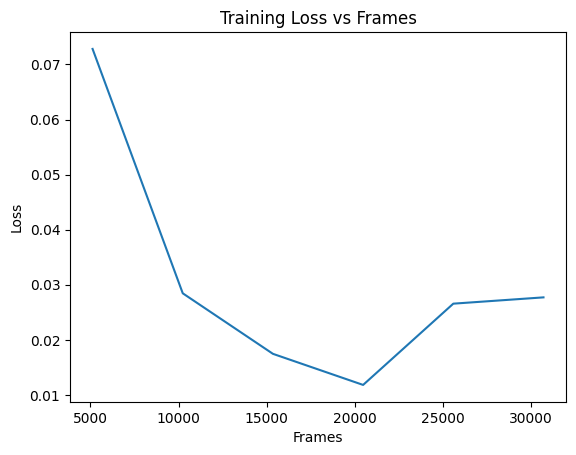

ValueError: could not convert string to float: ''

In [6]:
# Cell 5: Plot training/eval curves
import os
from agentslab.runner.curves import plot_training, plot_eval

train_csv = os.path.join(PATHS.logs_path, "train.csv")
eval_csv = os.path.join(PATHS.logs_path, "eval.csv")
plot_training(train_csv)
plot_eval(eval_csv)


In [9]:
# Cell 6: Run a rendered episode (if supported by the env/render_mode)
from torchrl.envs import ExplorationType, set_exploration_type
from torchrl.envs.utils import step_mdp
import torch

render_cfg = EnvConfig(env_id=ENV_CFG.env_id, seed=ENV_CFG.seed, render_mode="human")
env = make_env(render_cfg.env_id, render_cfg.seed, render_cfg.render_mode)

with torch.no_grad(), set_exploration_type(ExplorationType.MODE):
    td = env.reset()
    total_r = 0.0
    for _ in range(10000):
        td = policy(td.to(DEVICE))
        td = env.step(td)
        r = float(td.get(("next", "reward")).item())
        total_r += r
        done = bool(td.get(("next", "done")).item())
        td = step_mdp(td)
        if done:
            break
env.close()
print("Episode return (rendered):", total_r)


Episode return (rendered): 10.0


In [10]:
# Cell 7: Restore agent from latest checkpoint
import os, torch
from agentslab.runner.checkpointer import Checkpointer

ckpt = Checkpointer(PATHS.ckpt_path)
latest = ckpt.latest()
print("Latest checkpoint:", latest)
if latest:
    data = Checkpointer.load_into(latest, policy=policy, q_net=q_net, optimizer=optimizer, loss_module=loss_module, map_location=DEVICE)
    print("Loaded step:", data.get("step"))


Latest checkpoint: None
